In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score



password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

### Read the data into a Pandas dataframe.

In [2]:
# features that I think impact a film rental decision: rating, rental_rate, rental_duration, release_year, language, category. 
#I use case to add a column for renated in feb as it is requested in the lab. I use Max(rental_date) to find the latest rental date.

query = '''SELECT f.film_id, f.title, f.rating,f.rental_rate,f.rental_duration, f.release_year, l.name AS language, c.name As category,
  COUNT(DISTINCT rental_id) AS rental_counts, 
  CASE WHEN MAX(rental_date) >= '2006-02-01' AND MAX(rental_date) < '2006-03-01' THEN TRUE ELSE FALSE END AS rented_in_feb
FROM sakila.film AS f
JOIN inventory AS i
USING (film_id)
JOIN rental AS r
USING (inventory_id)
JOIN language AS l
USING (language_id)
JOIN film_category AS fc
USING (film_id)
JOIN category AS c
USING (category_id)
GROUP BY f.film_id,f.title, f.rating, language, category;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,rating,rental_rate,rental_duration,release_year,language,category,rental_counts,rented_in_feb
0,1,ACADEMY DINOSAUR,PG,0.99,6,2006,English,Documentary,24,0
1,2,ACE GOLDFINGER,G,4.99,3,2006,English,Horror,7,1
2,3,ADAPTATION HOLES,NC-17,2.99,7,2006,English,Documentary,12,0
3,4,AFFAIR PREJUDICE,G,2.99,5,2006,English,Horror,23,1
4,5,AFRICAN EGG,G,2.99,6,2006,English,Family,12,1


### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [3]:
data.shape

(958, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   film_id          958 non-null    int64  
 1   title            958 non-null    object 
 2   rating           958 non-null    object 
 3   rental_rate      958 non-null    float64
 4   rental_duration  958 non-null    int64  
 5   release_year     958 non-null    int64  
 6   language         958 non-null    object 
 7   category         958 non-null    object 
 8   rental_counts    958 non-null    int64  
 9   rented_in_feb    958 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 75.0+ KB


In [5]:
data.isna().sum() 


film_id            0
title              0
rating             0
rental_rate        0
rental_duration    0
release_year       0
language           0
category           0
rental_counts      0
rented_in_feb      0
dtype: int64

In [6]:
data['title'].value_counts()

ACADEMY DINOSAUR      1
PERSONAL LADYBUGS     1
PARK CITIZEN          1
PARTY KNOCK           1
PAST SUICIDES         1
                     ..
FULL FLATLINERS       1
FURY MURDER           1
GABLES METROPOLIS     1
GALAXY SWEETHEARTS    1
ZORRO ARK             1
Name: title, Length: 958, dtype: int64

In [7]:
data.rental_rate.unique() #there are different rental rates that can affect the rental decision

array([0.99, 4.99, 2.99])

In [8]:
data.rental_duration.unique() #there are different rental durations that can affect the rental decision

array([6, 3, 7, 5, 4])

In [9]:
data.language.unique()

array(['English'], dtype=object)

In [10]:
data.release_year.unique()

array([2006])

In [11]:
data= data.drop(['language', 'release_year'], axis=1) 
#I will drop the language and the release_year since all the films are in English and have been released in 2006.

In [12]:
data.head()

,film_id,title,rating,rental_rate,rental_duration,category,rental_counts,rented_in_feb
0,1,ACADEMY DINOSAUR,PG,0.99,6,Documentary,24,0
1,2,ACE GOLDFINGER,G,4.99,3,Horror,7,1
2,3,ADAPTATION HOLES,NC-17,2.99,7,Documentary,12,0
3,4,AFFAIR PREJUDICE,G,2.99,5,Horror,23,1
4,5,AFRICAN EGG,G,2.99,6,Family,12,1


In [13]:
data.duplicated().any() #no dups

False

In [14]:
data.category.unique()

array(['Documentary', 'Horror', 'Family', 'Foreign', 'Comedy', 'Sports',
       'Music', 'Animation', 'Action', 'New', 'Sci-Fi', 'Classics',
       'Games', 'Children', 'Travel', 'Drama'], dtype=object)

In [15]:
data['category'].value_counts()

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          61
New            60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category, dtype: int64

### Cleaning the data

In [16]:
data['title']=data['title']. apply(str. lower)
data.head()

,film_id,title,rating,rental_rate,rental_duration,category,rental_counts,rented_in_feb
0,1,academy dinosaur,PG,0.99,6,Documentary,24,0
1,2,ace goldfinger,G,4.99,3,Horror,7,1
2,3,adaptation holes,NC-17,2.99,7,Documentary,12,0
3,4,affair prejudice,G,2.99,5,Horror,23,1
4,5,african egg,G,2.99,6,Family,12,1


In [17]:
data['rented_in_feb'].value_counts()

0    790
1    168
Name: rented_in_feb, dtype: int64

## Feature Engineering

#like Rachels suggestion I want to create a column that shows popularity based on the number a film was rented.

In [18]:
data['rental_counts'].max()#max times a movie was rented

34

In [19]:
data['rental_counts'].min()#min times a movie was rented

4

###  popularity scale: 
#### Rented >=25 --> very popular
#### 16  =< Rented <25 --> fairly popular
#### 8  =< Rented <16 --> Somewhat popular
#### Rented< 8 --> not poular

In [20]:
# writing a function for the new column

def categorize_popularity(x):
    if x >= 25:
        return "very_popular"
    if x>= 16:
        return "fairly_popular"
    if x>=8: 
        return "Somewhat_popular"
    else:
        return "not_popular"

data['popularity_level']=data['rental_counts'].apply(categorize_popularity)
data.head()

,film_id,title,rating,rental_rate,rental_duration,category,rental_counts,rented_in_feb,popularity_level
0,1,academy dinosaur,PG,0.99,6,Documentary,24,0,fairly_popular
1,2,ace goldfinger,G,4.99,3,Horror,7,1,not_popular
2,3,adaptation holes,NC-17,2.99,7,Documentary,12,0,Somewhat_popular
3,4,affair prejudice,G,2.99,5,Horror,23,1,fairly_popular
4,5,african egg,G,2.99,6,Family,12,1,Somewhat_popular


In [21]:
data.describe()

,film_id,rental_rate,rental_duration,rental_counts,rented_in_feb
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,2.977474,4.969729,16.748434,0.175365
std,287.541738,1.643152,1.407593,6.677241,0.380478
min,1.000000,0.990000,3.000000,4.000000,0.000000
25%,256.250000,0.990000,4.000000,11.000000,0.000000
50%,504.500000,2.990000,5.000000,16.000000,0.000000
75%,751.750000,4.990000,6.000000,22.000000,0.000000
max,1000.000000,4.990000,7.000000,34.000000,1.000000


### Seperating target and input variables

In [22]:
# Target varible
y = data['rented_in_feb'] 

#input variables
x =data.drop(['rented_in_feb'], axis=1) 

y.head()


0    0
1    1
2    0
3    1
4    1
Name: rented_in_feb, dtype: int64

In [23]:
x.head()

,film_id,title,rating,rental_rate,rental_duration,category,rental_counts,popularity_level
0,1,academy dinosaur,PG,0.99,6,Documentary,24,fairly_popular
1,2,ace goldfinger,G,4.99,3,Horror,7,not_popular
2,3,adaptation holes,NC-17,2.99,7,Documentary,12,Somewhat_popular
3,4,affair prejudice,G,2.99,5,Horror,23,fairly_popular
4,5,african egg,G,2.99,6,Family,12,Somewhat_popular


## categorical Variables

In [24]:
# split into numerical and categorical
x_cat = x.select_dtypes(include = np.object)
x_cat.head()

/var/folders/bh/f8xvxphx21xcjth6jlc7q5yr0000gn/T/ipykernel_34093/4066365316.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_cat = x.select_dtypes(include = np.object)


,title,rating,category,popularity_level
0,academy dinosaur,PG,Documentary,fairly_popular
1,ace goldfinger,G,Horror,not_popular
2,adaptation holes,NC-17,Documentary,Somewhat_popular
3,affair prejudice,G,Horror,fairly_popular
4,african egg,G,Family,Somewhat_popular


### encoding categoricals

In [25]:
#droping title

x_cat= x_cat.drop(['title'], axis=1) 
x_cat.head()

,rating,category,popularity_level
0,PG,Documentary,fairly_popular
1,G,Horror,not_popular
2,NC-17,Documentary,Somewhat_popular
3,G,Horror,fairly_popular
4,G,Family,Somewhat_popular


In [26]:
x_cat_dummy = pd.get_dummies(x_cat, columns=['rating','category', 'popularity_level'])
x_cat_dummy.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,...,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,popularity_level_Somewhat_popular,popularity_level_fairly_popular,popularity_level_not_popular,popularity_level_very_popular
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Numerical Variables

In [27]:
x_num = x.select_dtypes(include = np.number)
x_num.head()

,film_id,rental_rate,rental_duration,rental_counts
0,1,0.99,6,24
1,2,4.99,3,7
2,3,2.99,7,12
3,4,2.99,5,23
4,5,2.99,6,12


In [28]:
# drop column film_id 

x_num = x_num.drop(['film_id'], axis = 1)
x_num.head()

,rental_rate,rental_duration,rental_counts
0,0.99,6,24
1,4.99,3,7
2,2.99,7,12
3,2.99,5,23
4,2.99,6,12


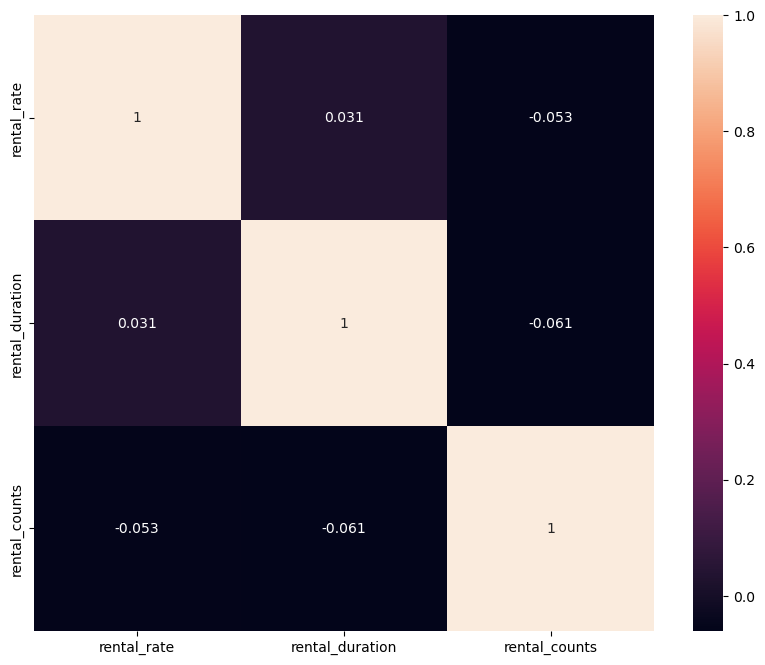

In [29]:
corr_matrix=x_num.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### rental_rate has an opposite relationship with number of times a film is rented, this is also the case for rental_duration.


/Users/hamidehaghaei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rental_counts', ylabel='Density'>

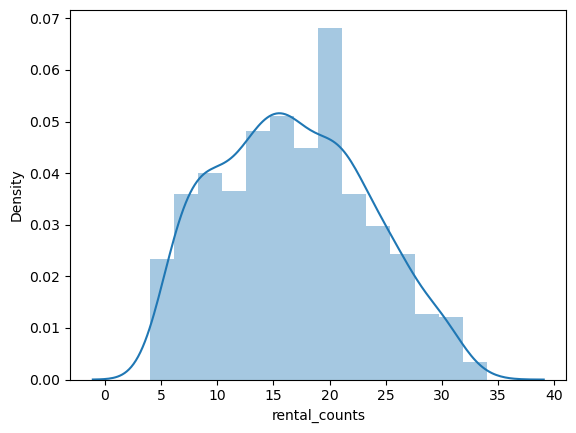

In [30]:
sns.distplot(x_num.rental_counts)

/Users/hamidehaghaei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rental_duration', ylabel='Density'>

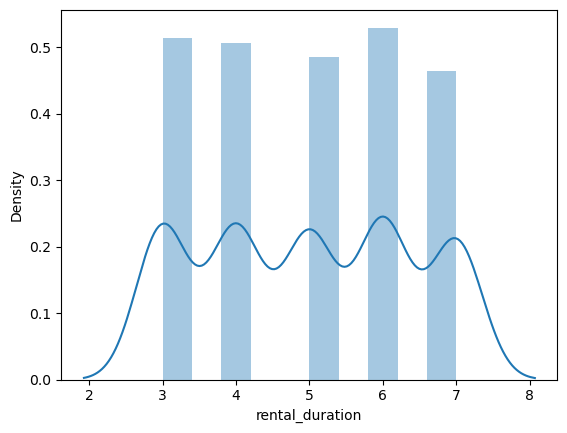

In [31]:
sns.distplot(x_num.rental_duration)

/Users/hamidehaghaei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rental_rate', ylabel='Density'>

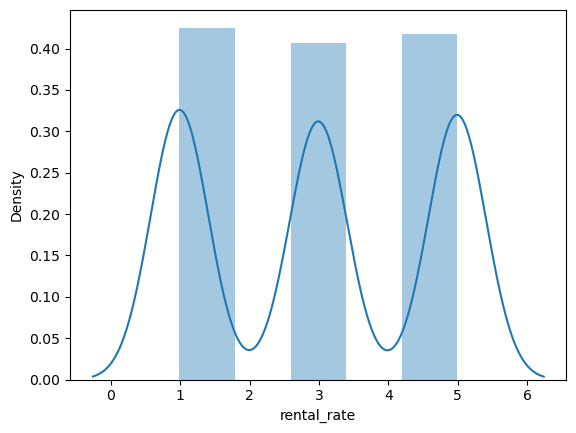

In [32]:
sns.distplot(x_num.rental_rate)

### Normalizing the numercial data

In [33]:
# scale numerical features

from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(x_num)
x_num_minmax = transformer.transform(x_num) 
x_num_norm = pd.DataFrame(x_num_minmax,columns= x_num.columns)
x_num_norm.head()

,rental_rate,rental_duration,rental_counts
0,0.0,0.75,0.666667
1,1.0,0.00,0.100000
2,0.5,1.00,0.266667
3,0.5,0.50,0.633333
4,0.5,0.75,0.266667


### Concating X categorical and X num

In [34]:
# concat dataframes

X = pd.concat([x_num_norm, x_cat_dummy], axis=1)
X.head()

,rental_rate,rental_duration,rental_counts,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Action,category_Animation,...,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,popularity_level_Somewhat_popular,popularity_level_fairly_popular,popularity_level_not_popular,popularity_level_very_popular
0,0.0,0.75,0.666667,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0.00,0.100000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.5,1.00,0.266667,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.5,0.50,0.633333,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.5,0.75,0.266667,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Train-Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (670, 28)
y_train shape: (670,)
X_test shape: (288, 28)
y_test shape: (288,)


### Training Model

In [36]:
# We traing the training dataset using Logistic Regression (multiclass classification)
classification = LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train, y_train)


In [37]:
# We predict on the testing dataset
predictions = classification.predict(X_test)

### Check how well the model performs

In [38]:
pd.Series(predictions).value_counts()

0    288
dtype: int64

In [39]:
y_test.value_counts()

0    234
1     54
Name: rented_in_feb, dtype: int64

In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy = {accuracy:.2f}")


Accuracy = 0.81


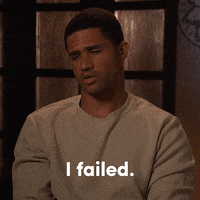

### with this model we could predict the 0 values with a good accuracy (movie not rented in Feb 2006) but we could not predict the 1 values (movies rented in Feb 2006)

### Confusion Matrix

In [46]:
confusion_matrix(y_test, predictions)

array([[234,   0],
       [ 54,   0]])

The Kappa of your model is: 0.00


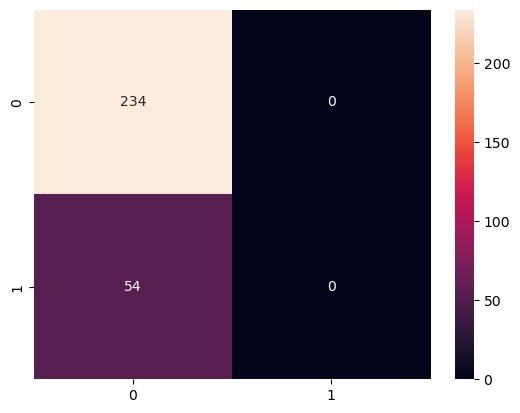

In [45]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm1, annot=True,fmt='g') 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

The kappa score is 0, som the model is not performing any better than random chance in terms of classifying the data points into their respective classes.